## Import Libraries

In [25]:
import os
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms, models
from collections import Counter
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, GaussianBlur, Grayscale
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset, Dataset

import cv2 
from PIL import Image, ImageFilter, ImageOps
from torchvision.transforms.functional import to_pil_image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.optim import lr_scheduler

from tkinter import filedialog, Tk

# from gradcam import GradCAM, GradCAMpp
# from gradcam.utils import visualize_cam

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import dill
import torch.multiprocessing as mp

# from captum.attr import IntegratedGradients
# from captum.attr import visualization as viz

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # as M1 Mac Does not have a dedicated GPU

##### Specify the path to the locally saved dataset

In [27]:
train_data_dir = '/Users/tharanidissanayake/downloads/AugmentedAlzheimerDataset'
original_dataset = datasets.ImageFolder(train_data_dir)

In [28]:
class ContrastStretching:
    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)
        
        # Check if the image is grayscale or RGB
        if img_np.ndim == 2:  # Grayscale image
            img_np = self.apply_contrast_stretching(img_np)
        elif img_np.ndim == 3:  # RGB image
            # Apply contrast stretching to each channel individually
            for i in range(img_np.shape[-1]):
                img_np[:, :, i] = self.apply_contrast_stretching(img_np[:, :, i])
        
        # Convert back to PIL Image
        return Image.fromarray(img_np.astype('uint8'))
    
    def apply_contrast_stretching(self, channel):
        in_min, in_max = np.percentile(channel, (0, 100))
        out_min, out_max = 0, 255
        channel = np.clip((channel - in_min) * (out_max - out_min) / (in_max - in_min) + out_min, out_min, out_max)
        return channel

class UnsharpMask:
    def __init__(self, radius=1, percent=100, threshold=3):
        self.radius = radius
        self.percent = percent
        self.threshold = threshold

    def __call__(self, img):
        return img.filter(ImageFilter.UnsharpMask(radius=self.radius, 
                                                  percent=self.percent, 
                                                  threshold=self.threshold
                                                 ))

class GaussianBlur:
    def __init__(self, kernel_size, sigma=(0.1, 2.0)):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        sigma = np.random.uniform(self.sigma[0], self.sigma[1])
        img = img.filter(ImageFilter.GaussianBlur(sigma))
        return img

#### Preprocess the dataset

In [29]:
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    ContrastStretching(),
    UnsharpMask(radius=1, percent=100, threshold=3),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
])

preprocessed_dataset = datasets.ImageFolder(root=train_data_dir, transform=preprocess_transform)

data_loader = DataLoader(preprocessed_dataset, batch_size=32, shuffle=True)

In [30]:
def calculate_psnr_ssim(original_dataset, preprocessed_dataset, num_samples=100, resize=(224, 224)):
    psnr_values = []
    ssim_values = []

    for i in range(num_samples):
        original_img = original_dataset[i][0] # original MRI
        preprocessed_img = preprocessed_dataset[i][0] # preprocessed MRI

        if not isinstance(original_img, Image.Image):
            original_img = to_pil_image(original_img)
        if not isinstance(preprocessed_img, Image.Image):
            preprocessed_img = to_pil_image(preprocessed_img)

        # Convert MRI to grayscale
        original_img = original_img.convert("L")
        preprocessed_img = preprocessed_img.convert("L")

        # Resize images
        original_img = original_img.resize(resize)
        preprocessed_img = preprocessed_img.resize(resize)

        # Convert images to numpy arrays
        original_img_np = np.array(original_img)
        preprocessed_img_np = np.array(preprocessed_img)

        # Calculate PSNR and SSIM
        psnr = peak_signal_noise_ratio(original_img_np, preprocessed_img_np, data_range=original_img_np.max() - original_img_np.min())
        ssim = structural_similarity(original_img_np, preprocessed_img_np)

        psnr_values.append(psnr)
        ssim_values.append(ssim)

    # Compute average PSNR and SSIM
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim

# Example usage
avg_psnr, avg_ssim = calculate_psnr_ssim(original_dataset, preprocessed_dataset)
print(f"Average PSNR: {avg_psnr}, Average SSIM: {avg_ssim}")

Average PSNR: 27.15052521243229, Average SSIM: 0.899277780868436


preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.Lambda(lambda x: x.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))),
    transforms.ToTensor()
)

Average PSNR: 9.729432125669954, Average SSIM: 0.2833625979364462
____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    transforms.ToTensor()
)

Average PSNR: 10.2026194786185, Average SSIM: 0.32374658927511385
____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)), 
    transforms.ToTensor(),
)

Average PSNR: 34.479706650199184, Average SSIM: 0.9638484917028203

____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1.0)), 
    transforms.ToTensor(),
)

Average PSNR: 40.03000513450271, Average SSIM: 0.9923509776637894

____________________________________________________________________
preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=100, threshold=3))),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
)

Average PSNR: 28.919164968402907, Average SSIM: 0.9646276430637585

____________________________________________________________________
preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    ContrastStretching(),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=1, percent=100, threshold=3))),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
)

Average PSNR: 27.194490517269728, Average SSIM: 0.8948121010151182

#### MRI scan counts in each class of the dataset

In [31]:
MildDemented = '/Users/tharanidissanayake/downloads/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented = '/Users/tharanidissanayake/downloads/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented = '/Users/tharanidissanayake/downloads/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented = '/Users/tharanidissanayake/downloads/AugmentedAlzheimerDataset/VeryMildDemented'

count_MildDemented = len(os.listdir(MildDemented))
count_ModerateDemented = len(os.listdir(ModerateDemented))
count_NonDemented = len(os.listdir(NonDemented))
count_VeryMildDemented = len(os.listdir(VeryMildDemented))

print(f"Number of images in MildDemented: {count_MildDemented}")
print(f"Number of images in ModerateDemented: {count_ModerateDemented}")
print(f"Number of images in NonDemented: {count_NonDemented}")
print(f"Number of images in VeryMildDemented: {count_VeryMildDemented}")

print(f"\nTotal MRIs in the dataset = {count_MildDemented+count_ModerateDemented+count_NonDemented+count_VeryMildDemented}" )

Number of images in MildDemented: 8960
Number of images in ModerateDemented: 6464
Number of images in NonDemented: 9600
Number of images in VeryMildDemented: 8961

Total MRIs in the dataset = 33985


#### Sample MRI before and after preprocessing

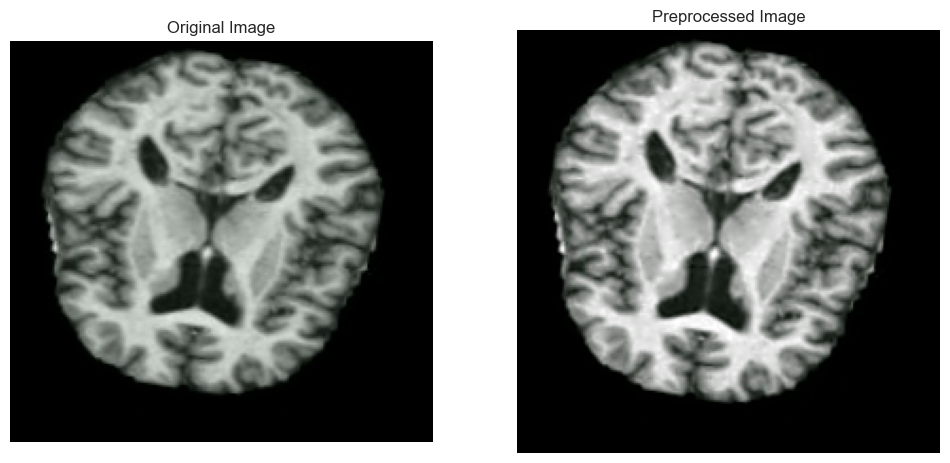

In [32]:
sample_image_path = os.path.join(MildDemented, os.listdir(MildDemented)[0])

original_image = Image.open(sample_image_path)

# Apply the preprocessing transforms
preprocessed_image = preprocess_transform(original_image)

preprocessed_image = transforms.ToPILImage()(preprocessed_image)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

### Dataset splitting & creating DataLoaders

In [33]:
train_size = int(0.70 * len(preprocessed_dataset))
val_size = int(0.15 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(preprocessed_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [34]:
all_labels = [label for _, label in train_dataset]
class_distribution = Counter(all_labels)
print(class_distribution)

Counter({2: 6752, 0: 6333, 3: 6256, 1: 4448})


## Building CNN Model 2

In [35]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=32):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn(self.conv(x)))
        out += residual
        return F.relu(out)

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomEfficientNet, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)
        
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a new one
        num_ftrs = self.base_model.classifier[1].in_features
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

        # Add SEBlock and ResidualBlock to the end of the features, before the avgpool
        self.base_model.features.add_module("SEBlock", SEBlock(1280))  # Adjust in_channels accordingly

    def forward(self, x):
        # Process through EfficientNet up to before avgpool
        x = self.base_model.features(x)
        
        # Now x is a 4D tensor, and we can apply SEBlock and ResidualBlock directly
        # No need for separate calls, as they are part of the features module
        
        # Apply avgpool and classifier
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Creating the model and moving to device
model2 = CustomEfficientNet(num_classes=4).to(device)

# For a summary, ensure the input size matches your dataset
summary(model2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

# Train Customized EfficientNet-B0

Epoch 1 [train] Progress: 100%|██████████| 186/186 [27:27<00:00,  8.86s/batch]


train Loss: 1.0071 Acc: 0.5430


Epoch 1 [val] Progress: 100%|██████████| 40/40 [05:49<00:00,  8.74s/batch]


val Loss: 0.8791 Acc: 0.5974


Epoch 2 [train] Progress: 100%|██████████| 186/186 [28:10<00:00,  9.09s/batch]


train Loss: 0.9187 Acc: 0.5827


Epoch 2 [val] Progress: 100%|██████████| 40/40 [05:52<00:00,  8.80s/batch]


val Loss: 0.8434 Acc: 0.6206


Epoch 3 [train] Progress: 100%|██████████| 186/186 [27:29<00:00,  8.87s/batch]


train Loss: 0.8673 Acc: 0.6073


Epoch 3 [val] Progress: 100%|██████████| 40/40 [05:37<00:00,  8.45s/batch]


val Loss: 0.7904 Acc: 0.6402


Epoch 4 [train] Progress: 100%|██████████| 186/186 [27:31<00:00,  8.88s/batch]


train Loss: 0.8260 Acc: 0.6304


Epoch 4 [val] Progress: 100%|██████████| 40/40 [05:39<00:00,  8.50s/batch]


val Loss: 0.7545 Acc: 0.6614


Epoch 5 [train] Progress: 100%|██████████| 186/186 [27:20<00:00,  8.82s/batch]


train Loss: 0.7975 Acc: 0.6466


Epoch 5 [val] Progress: 100%|██████████| 40/40 [05:37<00:00,  8.44s/batch]


val Loss: 0.7494 Acc: 0.6588


Epoch 6 [train] Progress: 100%|██████████| 186/186 [27:26<00:00,  8.85s/batch]


train Loss: 0.7643 Acc: 0.6585


Epoch 6 [val] Progress: 100%|██████████| 40/40 [05:36<00:00,  8.42s/batch]


val Loss: 0.7223 Acc: 0.6792


Epoch 7 [train] Progress: 100%|██████████| 186/186 [27:12<00:00,  8.78s/batch]


train Loss: 0.7408 Acc: 0.6675


Epoch 7 [val] Progress: 100%|██████████| 40/40 [05:36<00:00,  8.41s/batch]


val Loss: 0.7091 Acc: 0.6843


Epoch 8 [train] Progress: 100%|██████████| 186/186 [27:15<00:00,  8.79s/batch]


train Loss: 0.7254 Acc: 0.6822


Epoch 8 [val] Progress: 100%|██████████| 40/40 [05:35<00:00,  8.39s/batch]


val Loss: 0.7010 Acc: 0.6918


Epoch 9 [train] Progress: 100%|██████████| 186/186 [27:15<00:00,  8.80s/batch]


train Loss: 0.6984 Acc: 0.6962


Epoch 9 [val] Progress: 100%|██████████| 40/40 [05:36<00:00,  8.41s/batch]


val Loss: 0.6803 Acc: 0.6979


Epoch 10 [train] Progress: 100%|██████████| 186/186 [27:13<00:00,  8.78s/batch]


train Loss: 0.6789 Acc: 0.7034


Epoch 10 [val] Progress: 100%|██████████| 40/40 [05:38<00:00,  8.46s/batch]


val Loss: 0.6740 Acc: 0.6994


Epoch 11 [train] Progress: 100%|██████████| 186/186 [27:10<00:00,  8.76s/batch]


train Loss: 0.6584 Acc: 0.7145


Epoch 11 [val] Progress: 100%|██████████| 40/40 [05:33<00:00,  8.33s/batch]


val Loss: 0.6601 Acc: 0.7126


Epoch 12 [train] Progress: 100%|██████████| 186/186 [27:02<00:00,  8.72s/batch]


train Loss: 0.6410 Acc: 0.7232


Epoch 12 [val] Progress: 100%|██████████| 40/40 [05:34<00:00,  8.36s/batch]


val Loss: 0.6531 Acc: 0.7096


Epoch 13 [train] Progress: 100%|██████████| 186/186 [27:05<00:00,  8.74s/batch]


train Loss: 0.6289 Acc: 0.7314


Epoch 13 [val] Progress: 100%|██████████| 40/40 [05:31<00:00,  8.29s/batch]


val Loss: 0.6415 Acc: 0.7220


Epoch 14 [train] Progress: 100%|██████████| 186/186 [27:12<00:00,  8.78s/batch]


train Loss: 0.6113 Acc: 0.7395


Epoch 14 [val] Progress: 100%|██████████| 40/40 [05:35<00:00,  8.38s/batch]


val Loss: 0.6319 Acc: 0.7234


Epoch 15 [train] Progress: 100%|██████████| 186/186 [26:58<00:00,  8.70s/batch]


train Loss: 0.6015 Acc: 0.7454


Epoch 15 [val] Progress: 100%|██████████| 40/40 [05:31<00:00,  8.29s/batch]


val Loss: 0.6555 Acc: 0.7136


Epoch 16 [train] Progress: 100%|██████████| 186/186 [26:50<00:00,  8.66s/batch]


train Loss: 0.5845 Acc: 0.7508


Epoch 16 [val] Progress: 100%|██████████| 40/40 [05:36<00:00,  8.42s/batch]


val Loss: 0.6381 Acc: 0.7191


Epoch 17 [train] Progress: 100%|██████████| 186/186 [27:07<00:00,  8.75s/batch]


train Loss: 0.5739 Acc: 0.7570


Epoch 17 [val] Progress: 100%|██████████| 40/40 [05:43<00:00,  8.58s/batch]


val Loss: 0.6348 Acc: 0.7242


Epoch 18 [train] Progress: 100%|██████████| 186/186 [27:39<00:00,  8.92s/batch]


train Loss: 0.5672 Acc: 0.7614


Epoch 18 [val] Progress: 100%|██████████| 40/40 [05:39<00:00,  8.48s/batch]


val Loss: 0.6341 Acc: 0.7259


Epoch 19 [train] Progress: 100%|██████████| 186/186 [27:24<00:00,  8.84s/batch]


train Loss: 0.5564 Acc: 0.7665


Epoch 19 [val] Progress: 100%|██████████| 40/40 [05:33<00:00,  8.33s/batch]


val Loss: 0.6289 Acc: 0.7332


Epoch 20 [train] Progress: 100%|██████████| 186/186 [27:29<00:00,  8.87s/batch]


train Loss: 0.5454 Acc: 0.7705


Epoch 20 [val] Progress: 100%|██████████| 40/40 [05:34<00:00,  8.35s/batch]


val Loss: 0.6285 Acc: 0.7361


Epoch 21 [train] Progress: 100%|██████████| 186/186 [27:06<00:00,  8.75s/batch]


train Loss: 0.5333 Acc: 0.7785


Epoch 21 [val] Progress: 100%|██████████| 40/40 [05:34<00:00,  8.35s/batch]


val Loss: 0.6267 Acc: 0.7391


Epoch 22 [train] Progress: 100%|██████████| 186/186 [27:35<00:00,  8.90s/batch]


train Loss: 0.5331 Acc: 0.7762


Epoch 22 [val] Progress: 100%|██████████| 40/40 [05:40<00:00,  8.50s/batch]


val Loss: 0.6209 Acc: 0.7377


Epoch 23 [train] Progress: 100%|██████████| 186/186 [27:47<00:00,  8.96s/batch]


train Loss: 0.5160 Acc: 0.7872


Epoch 23 [val] Progress: 100%|██████████| 40/40 [05:43<00:00,  8.58s/batch]


val Loss: 0.6343 Acc: 0.7306


Epoch 24 [train] Progress: 100%|██████████| 186/186 [28:00<00:00,  9.03s/batch]


train Loss: 0.5094 Acc: 0.7930


Epoch 24 [val] Progress: 100%|██████████| 40/40 [05:44<00:00,  8.62s/batch]


val Loss: 0.6278 Acc: 0.7338


Epoch 25 [train] Progress: 100%|██████████| 186/186 [27:40<00:00,  8.93s/batch]


train Loss: 0.5026 Acc: 0.7944


Epoch 25 [val] Progress: 100%|██████████| 40/40 [05:33<00:00,  8.33s/batch]


val Loss: 0.6143 Acc: 0.7420


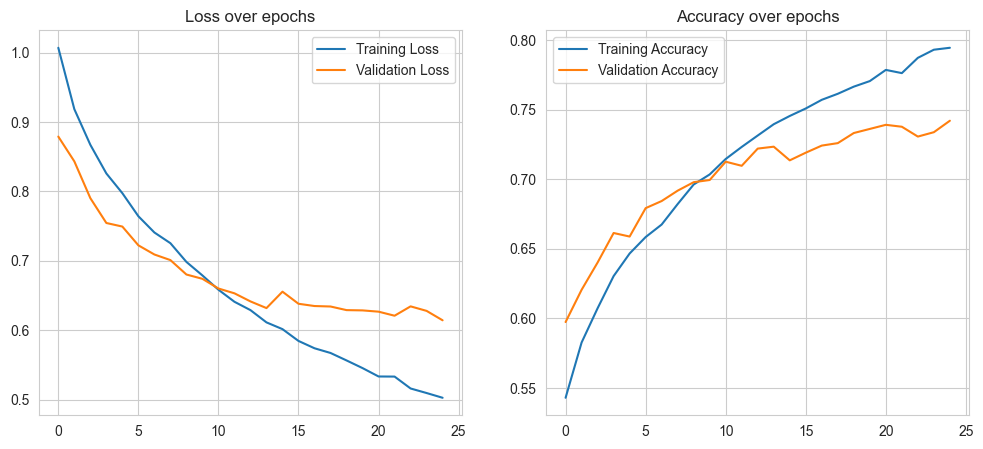

In [37]:
criterion = nn.CrossEntropyLoss()
trainable_params = filter(lambda p: p.requires_grad, model2.parameters())
optimizer = torch.optim.Adam(trainable_params, lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
torch.autograd.set_detect_anomaly(True)

def train_epoch(epoch_index, train_loader, model, optimizer):
    model.train()  
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    model.eval() 
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

# Training loop
num_epochs = 25
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
patience = 8

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, model2, optimizer)
    val_loss, val_acc = validate_epoch(epoch, val_loader, model2)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model2.state_dict(), 'model2_test5.pth')
#     else:
#         trigger_times += 1
#         if trigger_times >= patience:
#             print(f"Early stopping at epoch {epoch+1}")
#             break

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()  

 ### Classification Report of the trained Modified EfficientNet B0

In [38]:
# classification report (val loader)
model2 = CustomEfficientNet(num_classes=4).to(device)

model2.load_state_dict(torch.load('model2_test5.pth'))

def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(model2, val_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.71      0.77      0.74      1356
ModerateDemented       0.91      0.96      0.93       987
     NonDemented       0.74      0.69      0.71      1407
VeryMildDemented       0.64      0.60      0.62      1347

        accuracy                           0.74      5097
       macro avg       0.75      0.76      0.75      5097
    weighted avg       0.74      0.74      0.74      5097


In [39]:
def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(model2, test_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       0.69      0.76      0.72      1271
ModerateDemented       0.93      0.94      0.93      1029
     NonDemented       0.75      0.70      0.72      1441
VeryMildDemented       0.63      0.61      0.62      1358

        accuracy                           0.74      5099
       macro avg       0.75      0.75      0.75      5099
    weighted avg       0.74      0.74      0.74      5099


In [ ]:
# Confusion Matrix on Test Loader - modified EfficientNet B0

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(model2, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Save the best model locally (model2 - modified EfficientNetB0)

model_save_path = '/Users/tharanidissanayake/desktop' 
os.makedirs(model_save_path, exist_ok=True) 
model_save_file = os.path.join(model_save_path, 'model2_test5.pth')

torch.save(model2.state_dict(), model_save_file)

print(f'Model saved to {model_save_file}')